In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FGJ_carpetas = pd.read_csv("../Data/FGJ_carpetas.csv", index_col=0, parse_dates=["fecha_hechos", "fecha_inicio"])
print(FGJ_carpetas.info())
print(FGJ_carpetas.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1390698 entries, 1 to 1484304
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   ao_hechos             1390698 non-null  int64         
 1   mes_hechos            1390698 non-null  object        
 2   fecha_hechos          1390698 non-null  datetime64[ns]
 3   ao_inicio             1390698 non-null  int64         
 4   mes_inicio            1390698 non-null  object        
 5   fecha_inicio          1390698 non-null  datetime64[ns]
 6   delito                1390698 non-null  object        
 7   fiscalia              1390698 non-null  object        
 8   agencia               1390698 non-null  object        
 9   unidad_investigacion  1390698 non-null  object        
 10  categoria_delito      1390698 non-null  object        
 11  colonia_hechos        1390698 non-null  object        
 12  alcaldia_hechos       1390698 non-null  ob

In [10]:
FGJ_carpetas["categoria_delito"].value_counts()

DELITO DE BAJO IMPACTO                                     1110775
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA         80354
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                         69732
HECHO NO DELICTIVO                                           49673
ROBO A NEGOCIO CON VIOLENCIA                                 22717
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                        14116
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA        11981
HOMICIDIO DOLOSO                                              6872
VIOLACIÓN                                                     6696
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO                 4765
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA       4738
ROBO A CASA HABITACIÓN CON VIOLENCIA                          3480
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA       2550
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA                 1414
ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA                      

<AxesSubplot:title={'center':'Tasa de delitos cometidos entre 2016-2022'}>

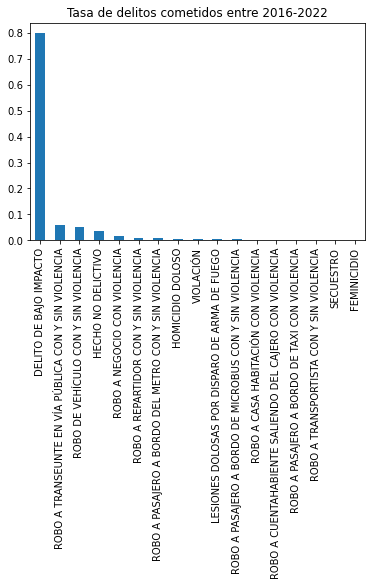

In [11]:
FGJ_carpetas["categoria_delito"].value_counts(normalize=True).plot(kind = "bar", 
                                                                   title = "Tasa de delitos cometidos entre 2016-2022")

In [16]:
FGJ_carpetas[FGJ_carpetas["categoria_delito"] == "DELITO DE BAJO IMPACTO"]["delito"].value_counts()[:20]

VIOLENCIA FAMILIAR                                                      159645
FRAUDE                                                                   86405
ROBO DE OBJETOS                                                          84110
AMENAZAS                                                                 83310
ROBO A NEGOCIO SIN VIOLENCIA                                             69059
ROBO DE ACCESORIOS DE AUTO                                               47406
ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO                              40210
ROBO A CASA HABITACION SIN VIOLENCIA                                     32645
DESPOJO                                                                  23875
ABUSO DE CONFIANZA                                                       23453
NARCOMENUDEO POSESION SIMPLE                                             21899
DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO VEHICULAR A AUTOMOVIL       21866
USURPACIÓN DE IDENTIDAD                             

In [28]:
FGJ_carpetas["ao_hechos"].value_counts().sort_index()

2016    187319
2017    218043
2018    244732
2019    235368
2020    195039
2021    211468
2022     98729
Name: ao_hechos, dtype: int64

<AxesSubplot:>

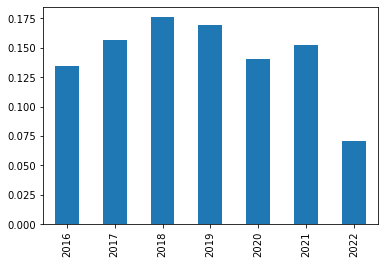

In [29]:
FGJ_carpetas["ao_hechos"].value_counts(normalize=True).sort_index().plot(kind = "bar")

In [33]:
FGJ_carpetas["mes_hechos"].value_counts().sort_index()

Abril         118921
Agosto        110892
Diciembre     102998
Enero         121395
Febrero       121297
Julio         106360
Junio         119038
Marzo         131641
Mayo          126749
Noviembre     108552
Octubre       115089
Septiembre    107766
Name: mes_hechos, dtype: int64

<AxesSubplot:>

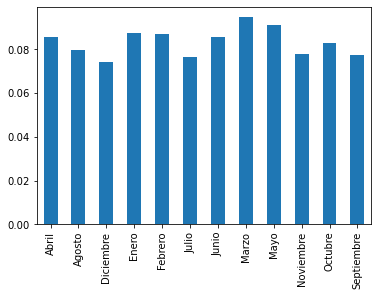

In [31]:
FGJ_carpetas["mes_hechos"].value_counts(normalize=True).sort_index().plot(kind = "bar")

In [26]:
delito_x_ao = pd.DataFrame(FGJ_carpetas.groupby(["ao_hechos"], as_index = False)["categoria_delito"].value_counts())

In [ ]:
FGJ_carpetas.groupby(["categoria_delito","ao_hechos"], as_index = False)

In [27]:
delito_x_ao.head()

,ao_hechos,categoria_delito,count
0,2016,DELITO DE BAJO IMPACTO,147384
1,2016,HECHO NO DELICTIVO,12116
2,2016,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,11758
3,2016,ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...,7066
4,2016,ROBO A NEGOCIO CON VIOLENCIA,2499


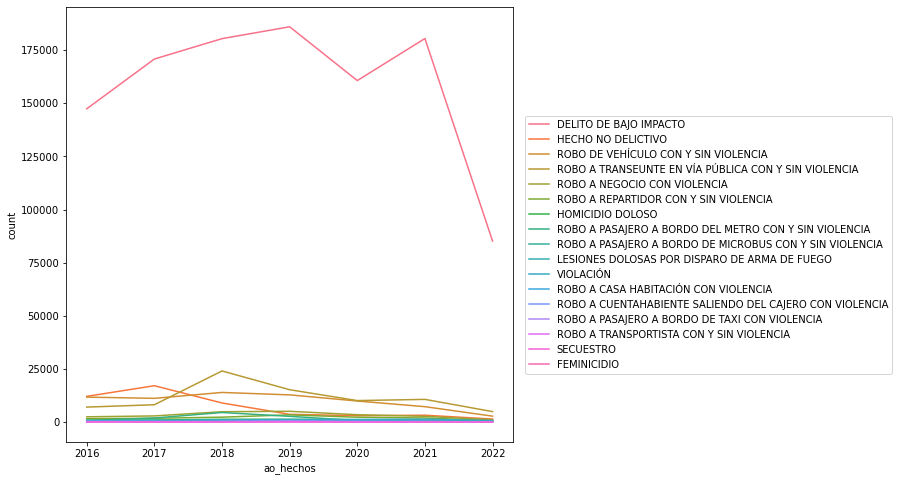

In [28]:
fig = plt.figure(figsize=(8, 8))
sns.lineplot(x="ao_hechos", y="count", hue="categoria_delito", data = delito_x_ao)
plt.legend(loc='upper right', borderaxespad=0, bbox_to_anchor=(1.85, 0.75))

In [3]:
categoria_x_dia = FGJ_carpetas.groupby(["fecha_hechos"], as_index = False)["categoria_delito"].value_counts()

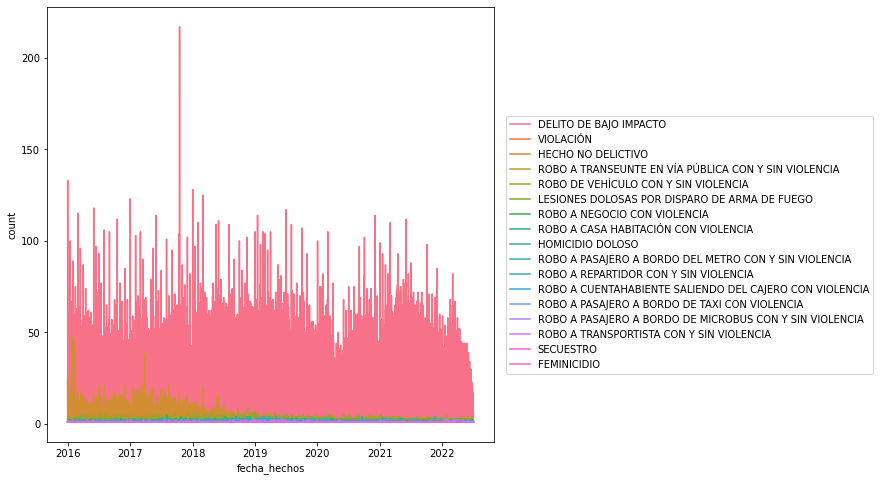

In [4]:
fig = plt.figure(figsize=(8, 8))
sns.lineplot(x="fecha_hechos", y="count", hue="categoria_delito", data = categoria_x_dia)
plt.legend(loc='upper right', borderaxespad=0, bbox_to_anchor=(1.85, 0.75))

In [5]:
FGJ_carpetas['fecha_hechos'].head(3).dt.day_name()

1    Sunday
2    Sunday
3    Monday
Name: fecha_hechos, dtype: object